In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
idx_to_class = {i:str(i) for i in range(10)}
print(idx_to_class)

image_size=28
num_classes=10
latent_dim=100

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}


In [6]:
# 생성자
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)  # -> 10*10 one-hot
        self.init_size = image_size // 4  # 7
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * self.init_size * self.init_size),
            nn.ReLU()
        )
        
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 7 -> 14
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # 14 ->28
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # [-1, 1] 출력 범위
        )
        
    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        out = self.l1(gen_input)  # (128 * 7 * 7)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 1)
        self.init_size = image_size // 4  # -> 7
        
        self.model = nn.Sequential(
            # 이미지 (1 채널)와 네이블 (1 채널)을 채널 차원에서 결합하여 2채널로 입력
            nn.Conv2d(1 + 1, 64, kernel_size=3, stride=2, padding=1),  # 28 -> 14
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 14 -> 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Flatten(),
            nn.Linear(128 * self.init_size * self.init_size, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img, labels):
        batch_size = img.size(0)
        label = self.label_emb(labels)
        label = label.view(batch_size, 1,1,1)
        label = label.expand(batch_size, 1, image_size, image_size)
        d_in = torch.cat((img, label), 1)
        output = self.model(d_in)
        return output

In [9]:
G = Generator().to(device)
D = Discriminator().to(device)

epochs = 30
criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

Epoch 1 / 30, d_loss0.0000, g_loss0.0000, D(x)0.73, D(G(z))0.27
Epoch 2 / 30, d_loss0.0000, g_loss0.0000, D(x)0.75, D(G(z))0.25
Epoch 3 / 30, d_loss0.0000, g_loss0.0000, D(x)0.75, D(G(z))0.25
Epoch 4 / 30, d_loss0.0000, g_loss0.0000, D(x)0.75, D(G(z))0.25
Epoch 5 / 30, d_loss0.0000, g_loss0.0000, D(x)0.75, D(G(z))0.25
Epoch 6 / 30, d_loss0.0000, g_loss0.0000, D(x)0.75, D(G(z))0.25
Epoch 7 / 30, d_loss0.0000, g_loss0.0000, D(x)0.75, D(G(z))0.25
Epoch 8 / 30, d_loss0.0000, g_loss0.0000, D(x)0.75, D(G(z))0.25
Epoch 9 / 30, d_loss0.0000, g_loss0.0000, D(x)0.73, D(G(z))0.27
Epoch 10 / 30, d_loss0.0000, g_loss0.0000, D(x)0.72, D(G(z))0.28


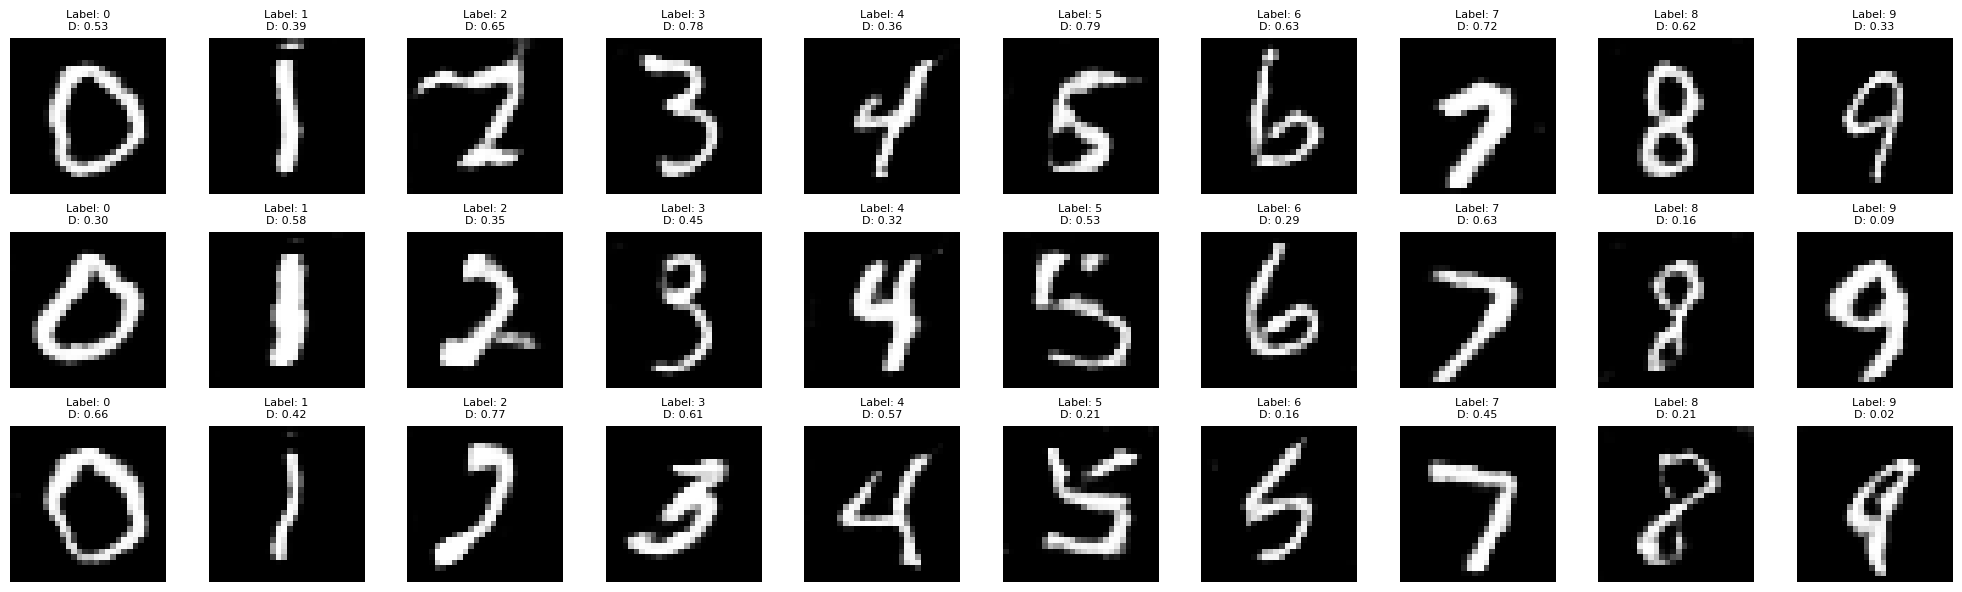

Epoch 11 / 30, d_loss0.0000, g_loss0.0000, D(x)0.72, D(G(z))0.28
Epoch 12 / 30, d_loss0.0000, g_loss0.0000, D(x)0.72, D(G(z))0.28
Epoch 13 / 30, d_loss0.0000, g_loss0.0000, D(x)0.72, D(G(z))0.28
Epoch 14 / 30, d_loss0.0000, g_loss0.0000, D(x)0.72, D(G(z))0.28
Epoch 15 / 30, d_loss0.0000, g_loss0.0000, D(x)0.72, D(G(z))0.28
Epoch 16 / 30, d_loss0.0000, g_loss0.0000, D(x)0.73, D(G(z))0.27
Epoch 17 / 30, d_loss0.0000, g_loss0.0000, D(x)0.73, D(G(z))0.27
Epoch 18 / 30, d_loss0.0000, g_loss0.0000, D(x)0.73, D(G(z))0.27
Epoch 19 / 30, d_loss0.0000, g_loss0.0000, D(x)0.73, D(G(z))0.26
Epoch 20 / 30, d_loss0.0000, g_loss0.0000, D(x)0.74, D(G(z))0.26


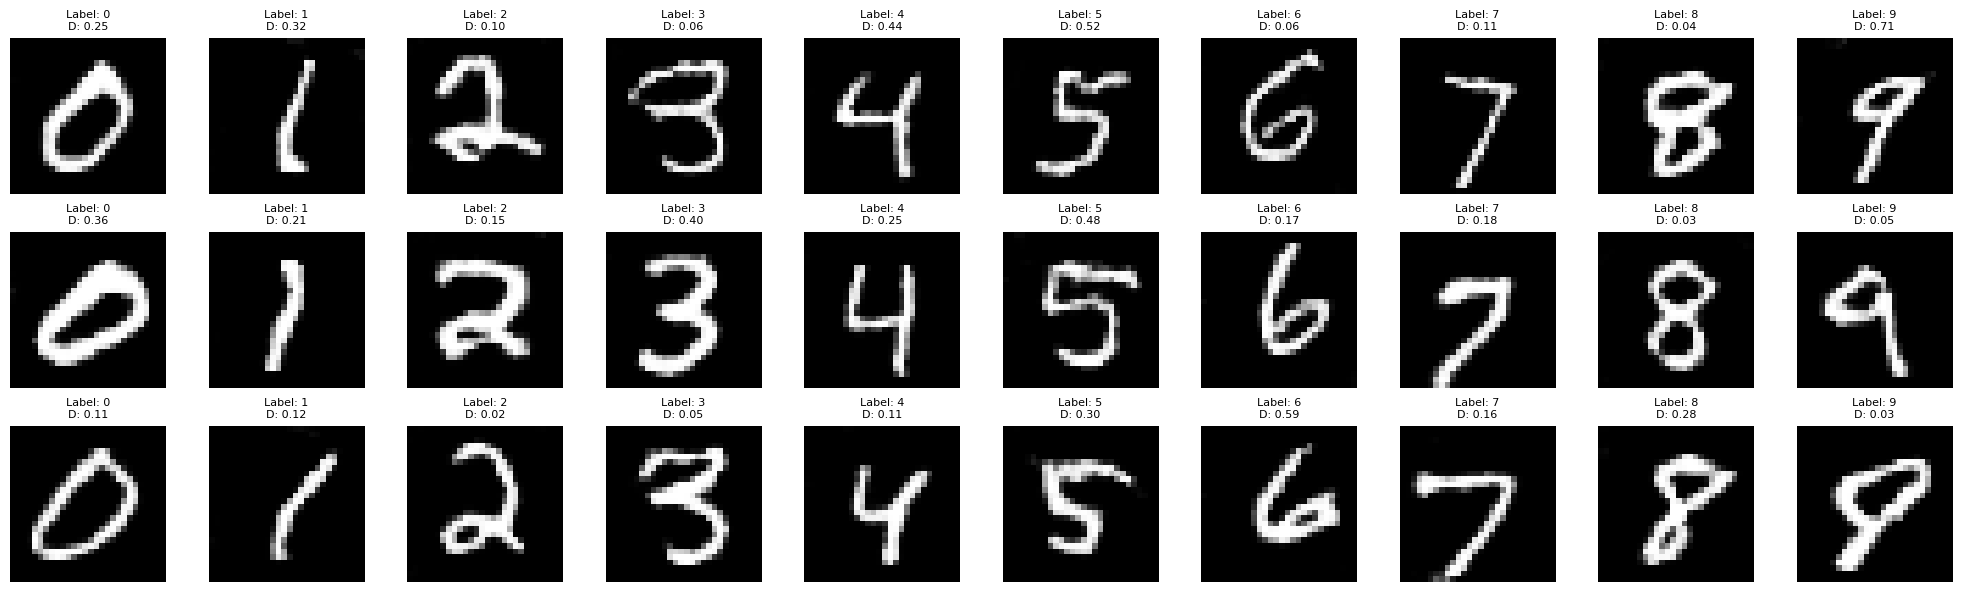

Epoch 21 / 30, d_loss0.0000, g_loss0.0000, D(x)0.74, D(G(z))0.26
Epoch 22 / 30, d_loss0.0000, g_loss0.0000, D(x)0.74, D(G(z))0.26
Epoch 23 / 30, d_loss0.0000, g_loss0.0000, D(x)0.74, D(G(z))0.26
Epoch 24 / 30, d_loss0.0000, g_loss0.0000, D(x)0.75, D(G(z))0.25
Epoch 25 / 30, d_loss0.0000, g_loss0.0000, D(x)0.75, D(G(z))0.25
Epoch 26 / 30, d_loss0.0000, g_loss0.0000, D(x)0.75, D(G(z))0.25
Epoch 27 / 30, d_loss0.0000, g_loss0.0000, D(x)0.75, D(G(z))0.25
Epoch 28 / 30, d_loss0.0000, g_loss0.0000, D(x)0.75, D(G(z))0.25
Epoch 29 / 30, d_loss0.0000, g_loss0.0000, D(x)0.75, D(G(z))0.25
Epoch 30 / 30, d_loss0.0000, g_loss0.0000, D(x)0.75, D(G(z))0.25


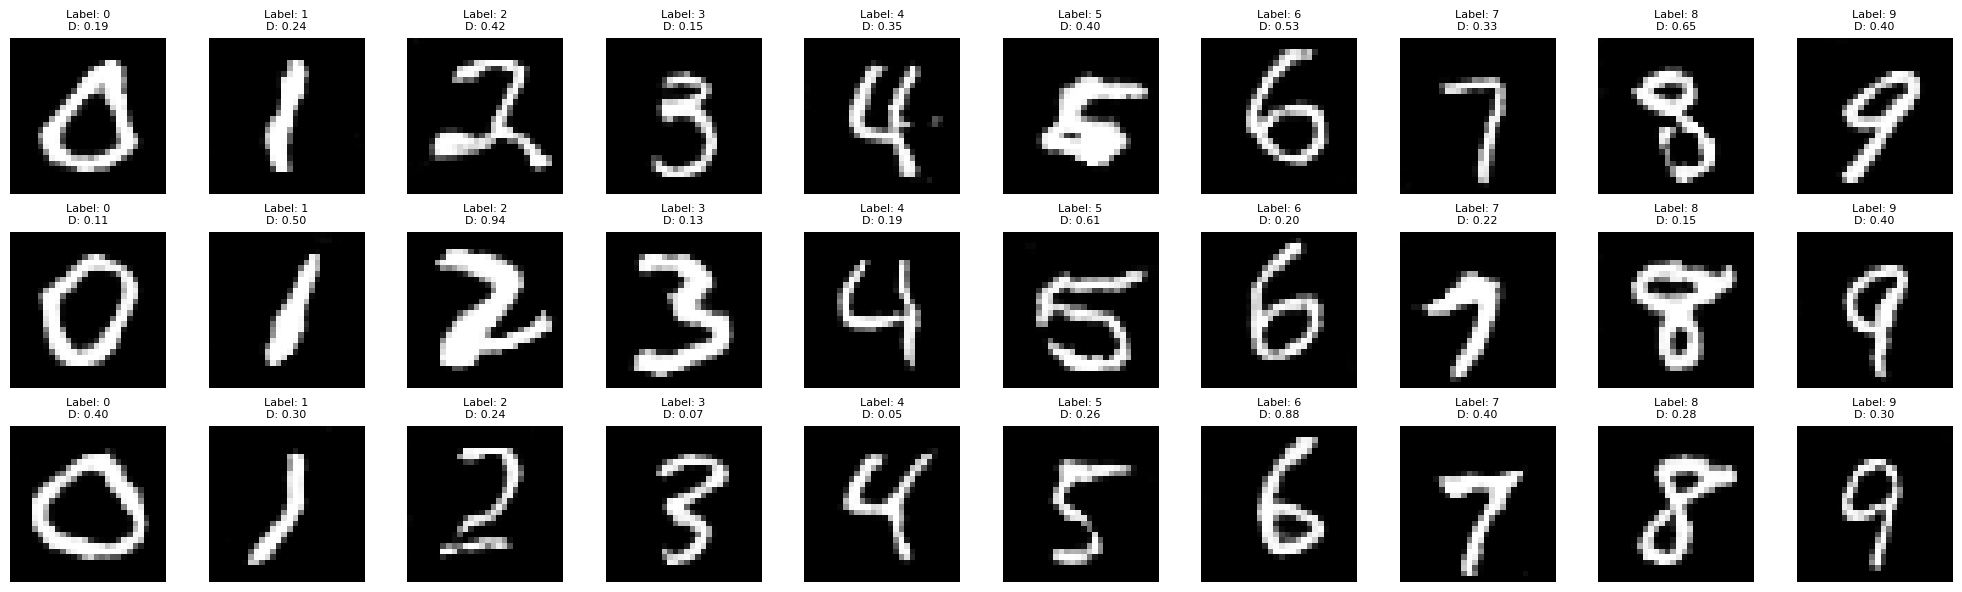

In [ ]:
for epoch in range(epochs):
    running_d_loss = 0
    running_g_loss = 0
    d_x_total = 0.0
    d_gz_total = 0.0
    total_samples = 0
    
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size_current = imgs.size(0)
        total_samples += batch_size_current
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        valid = torch.ones(batch_size_current, 1, device=device)
        fake = torch.zeros(batch_size_current, 1, device=device)
        
        # 판별자 학습
        opt_D.zero_grad()
        
        # 진짜 이미지 판별
        real_pred = D(imgs, labels)
        real_loss = criterion(real_pred, valid)
        d_x_total += real_pred.mean().item() * batch_size_current
        
        # 가짜 이미지 생성
        noise = torch.randn(batch_size_current, latent_dim, device=device)
        gen_labels = labels
        gen_img = G(noise, gen_labels)
        
        # 가짜 이미지 판별
        fake_pred = D(gen_img.detach(), labels)
        fake_loss = criterion(fake_pred, fake)
        d_gz_total += fake_pred.mean().item() * batch_size_current
        
        d_loss = real_loss + fake_loss
        d_loss.backward()
        opt_D.step()
        
        # 생성자 학습
        opt_G.zero_grad()
        g_loss = criterion(D(gen_img, labels), valid)
        g_loss.backward()
        opt_G.step()
    
    avg_d_loss = running_d_loss / total_samples
    avg_g_loss = running_g_loss / total_samples
    avg_d_x = d_x_total / total_samples
    avg_d_gz = d_gz_total / total_samples
    
    print(f'Epoch {epoch+1} / {epochs}, d_loss{avg_d_loss:.4f}, g_loss{avg_g_loss:.4f}, D(x){avg_d_x:.2f}, D(G(z)){avg_d_gz:.2f}')
    
    # 10 에포크마다 생성 이미지 시각화 (각 클래스별로 3개씩 출력)
    if (epoch + 1) % 10 == 0:
        G.eval()
        n_row = 3               # 각 클래스당 3개씩
        n_col = num_classes     # 총 10개 클래스
        total_samples_vis = n_row * n_col
        noise = torch.randn(total_samples_vis, latent_dim, device=device)
        labels_sample = torch.arange(0, num_classes, device=device).repeat(n_row)
        with torch.no_grad():
            gen_imgs = G(noise, labels_sample)
            disc_out = D(gen_imgs, labels_sample)
        gen_imgs = gen_imgs.detach().cpu().numpy()
        disc_out = disc_out.detach().cpu().numpy()

        fig, axs = plt.subplots(n_row, n_col, figsize=(n_col * 2, n_row * 2))
        for i in range(n_row):
            for j in range(n_col):
                idx = i * n_col + j
                axs[i, j].imshow(gen_imgs[idx, 0, :, :], cmap='gray')
                axs[i, j].axis('off')
                score = disc_out[idx, 0]
                axs[i, j].set_title(f"Label: {labels_sample[idx].item()}\nD: {score:.2f}", fontsize=8)
        plt.tight_layout()
        plt.show()
        G.train()